In [1]:
import os
from glob import glob
import numpy as np
from torch.utils import data
from torchvision.transforms import Compose, ToTensor
import tensorflow as tf

import cv2
import os

import matplotlib.pyplot as plt

input_transform = Compose([
   ToTensor(),
])

In [38]:
def torch_to_numpy(torch_tensor):
    if len(torch_tensor[0].shape) == 4:
        return np.transpose(torch_tensor[0].numpy(), [0, 2, 3, 1])
    else:
        return torch_tensor[0].numpy()

In [39]:
class seg_data(data.Dataset):
    def __init__(self, root, image_height=384, image_width=288, mode = None):
        self.img_files = glob(os.path.join(root, 'origs', '*'))
        self.label_root = os.path.join(root, 'masks/')
        self.index = 0
        self.img_height = image_height
        self.img_width = image_width
        self.mode = mode

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        path = self.img_files[index]
        img_name = os.path.basename(path)
        dirname = os.path.dirname(path)

        mask_path = os.path.join(dirname.replace('origs', 'masks'),
                                  '.'.join(img_name.split('.')[:-1]) + '.png')

        img = cv2.imread(path)[:,:,::-1]*1.0
        mask = cv2.imread(mask_path)[:,:,0]
        mask = np.where(mask>127, np.ones_like(mask)*255., np.zeros_like(mask)*1.0)


        # preproccess resize
        img_resized = cv2.resize(img, (self.img_width, self.img_height))
        mask_resized = cv2.resize(mask, (self.img_width, self.img_height),
                                  interpolation=cv2.INTER_NEAREST)

        if self.mode != 'test':
            # TODO make some real-time augmentations
            img_resized = img_resized
            mask_resized = mask_resized


        img_o = input_transform(img_resized) / 255.
        imgs = [img_o]

        mask_o = input_transform(np.expand_dims(mask_resized, axis = -1)) / 255.
        masks = [mask_o]

        return {'images':imgs, 'masks':masks}


class seg_data_test(data.Dataset):
    def __init__(self, root, image_height=384, image_width=288):
        self.img_files = glob(os.path.join(root, 'origs', '*'))
        self.index = 0
        self.img_height = image_height
        self.img_width = image_width

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        path = self.img_files[index]
        img = cv2.imread(path)[:, :, ::-1]
        name = '.'.join(os.path.basename(path).split('.')[:-1])

        # preproccess resize
        img_resized = cv2.resize(img, (self.img_width, self.img_height))*1.0
        mask_resized = np.zeros(shape = (self.img_height, self.img_width, 1)) * 1.0


        img_o = input_transform(img_resized) / 255.
        imgs = [img_o]

        mask_o = input_transform(mask_resized) / 255.
        masks = [mask_o]

        return {'images' : imgs, 'masks': masks, 'name': name}


In [40]:
dataset_path = 'dataset/'

In [41]:
dataloader_train = data.DataLoader(seg_data(root=os.path.join(dataset_path, 'train'),
                                                             image_height = 288,
                                                             image_width = 288),
                                                    batch_size = 1,
#                                                     num_workers=4,
#                                                     shuffle=True
                      )

In [42]:
# for idx, f_dict_train in enumerate(ddxk):
#     a =f_dict_train.values()
#     break

In [43]:
hyper_init_dict_train = dict()
hyper_init_dict_train['train_batch_norms'] = True
hyper_init_dict_train['learning_rate'] = 0.0001
hyper_init_dict_train['keep_prob'] = 0.7

In [44]:
hyper_init_dict_train

{'train_batch_norms': True, 'learning_rate': 0.0001, 'keep_prob': 0.7}

In [45]:
placeholders_dict = {'learning_rate': 0.0001}

placeholders_dict['keep_prob'] = tf.placeholder(tf.float32, name='keep_prob')
placeholders_dict['train_batch_norms'] = tf.placeholder_with_default(tf.constant(False, dtype=tf.bool),
                                                                          shape=(),
                                                                          name='train_batch_norms')
placeholders_dict['images'] = tf.placeholder(tf.float32, name='images',
                                                  shape=[None, 288, 288, 3])


placeholders_dict['masks'] = tf.placeholder(tf.float32, name='masks',
                                                  shape=[None, 288, 288, 1])

In [46]:
placeholders_dict

{'learning_rate': 0.0001,
 'keep_prob': <tf.Tensor 'keep_prob_1:0' shape=<unknown> dtype=float32>,
 'train_batch_norms': <tf.Tensor 'train_batch_norms_1:0' shape=() dtype=bool>,
 'images': <tf.Tensor 'images_1:0' shape=(?, 288, 288, 3) dtype=float32>,
 'masks': <tf.Tensor 'masks_1:0' shape=(?, 288, 288, 1) dtype=float32>}

In [47]:
for idx, f_dict_train in enumerate(dataloader_train):
#     assert isinstance(f_dict_train, dict)

    feed_dict_train = dict()
#     assert set(f_dict_train.keys()).union(set(hyper_init_dict_train.keys())) == \
#            set(placeholders_dict.keys())

    for key in placeholders_dict.keys():
        if key in f_dict_train.keys():
            feed_dict_train[placeholders_dict[key]] = torch_to_numpy(f_dict_train[key])
        else:
            feed_dict_train[placeholders_dict[key]] = hyper_init_dict_train[key]

In [48]:
img = list(feed_dict_train.values())[3]
msk = list(feed_dict_train.values())[4]

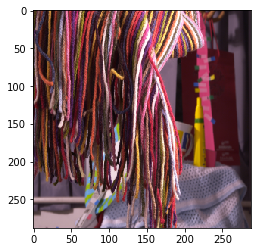

In [49]:
plt.imshow(img[0, :, :, :])
# print(img[0, :, :, :].shape)

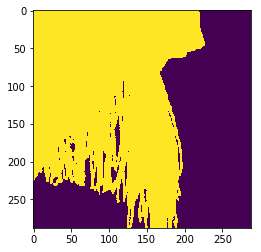

In [50]:
plt.imshow(msk[0, :, :, 0])

In [51]:
img.shape

(1, 288, 288, 3)

In [52]:
type(placeholders_dict['images'])

tensorflow.python.framework.ops.Tensor

In [53]:
s = tf.shape(placeholders_dict['images'])

In [54]:
s[2]

<tf.Tensor 'strided_slice_7:0' shape=() dtype=int32>

In [3]:
import sys
import os
import cv2
from skimage.io import imsave

# sys.path.insert(0, '/'.join(__file__.split('/')[:-3]))

In [4]:
color_path = '/'.join(os.path.dirname(__file__).split('/')[:-2])+'/bg_green.jpg'

NameError: name '__file__' is not defined

In [56]:
'/'.join(os.path.dirname(__file__).split('/')[:-2])+'/bg_green.jpg'

NameError: name '__file__' is not defined